Total operation time: 22044.00 seconds
Total hexagons within workspace: 2617
Number of visited hexagons: 1507
Coverage ratio: 0.5759


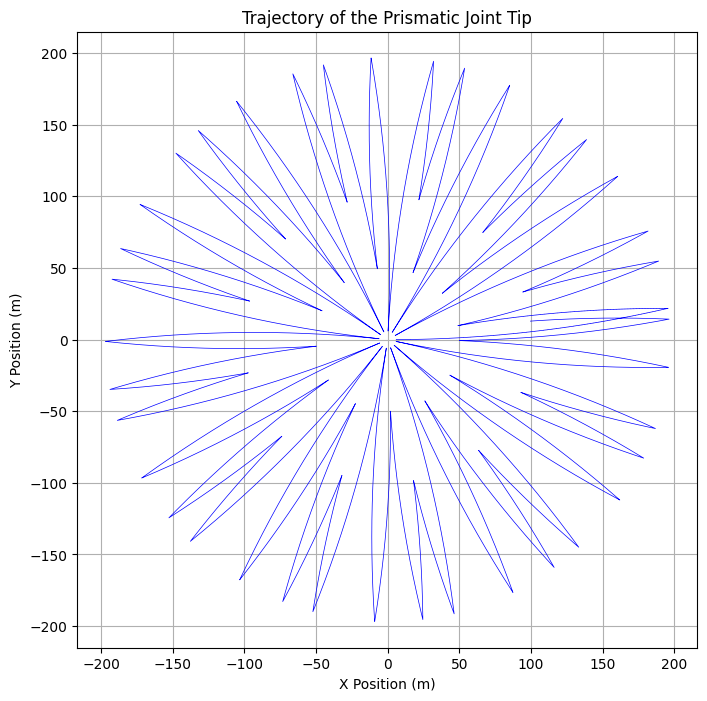

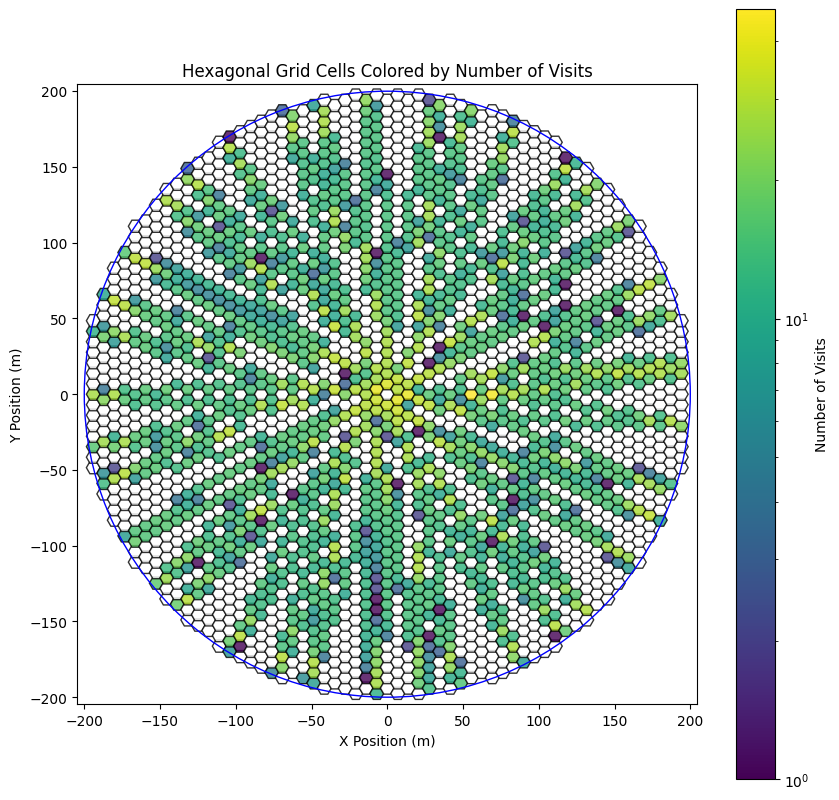

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib.colors import LogNorm, Normalize

# -----------------------------
# Parameters and Initialization
# -----------------------------

# Parameters for the prismatic and revolute joints
omega = np.pi / 10800  # Angular speed in rad/s (one full rotation in 6 hours)
L_max = 197            # Maximum extension in meters
v_max = 0.5            # Maximum speed in m/s

# Define minimum extension values
L_min_list = [6, 50, 100]  # Minimum extensions in meters

# Total operation time (e.g., 6 hours)
T_total = 6 * 3600  # Total operation time in seconds (21600 seconds)

# Initialize lists to store trajectory data
t = []             # Time stamps
r_values = []      # Radial distances
theta = []         # Angular positions

current_time = 0   # Initialize current time

# -----------------------------
# Motion Plan Implementation
# -----------------------------

# Repeat the sequence to fill the total operation time
while current_time < T_total:
    # Iterate over the L_min_list, moving between L_max and each L_min
    for i in range(len(L_min_list)):
        L_min_current = L_min_list[i]
        L_min_next = L_min_list[(i + 1) % len(L_min_list)]

        # Calculate time for extension and retraction
        t_extend = (L_max - L_min_current) / v_max
        t_retract = (L_max - L_min_next) / v_max

        # Total time for this segment
        T_segment = t_extend + t_retract

        # Generate time steps for this segment
        sampling_interval = 1  # Sampling every 1 second
        num_steps = int(np.ceil(T_segment / sampling_interval))
        segment_time_steps = current_time + np.arange(num_steps) * sampling_interval
        s = segment_time_steps - current_time

        # Append time stamps
        t.extend(segment_time_steps.tolist())

        # Initialize array to hold r values for this segment
        r_segment = np.zeros_like(s)

        # Calculate radial distances during extension and retraction
        idx_extend = s < t_extend
        r_segment[idx_extend] = L_min_current + v_max * s[idx_extend]
        idx_retract = s >= t_extend
        r_segment[idx_retract] = L_max - v_max * (s[idx_retract] - t_extend)

        # Append radial distances
        r_values.extend(r_segment.tolist())

        # Calculate angular positions for this segment
        theta_segment = omega * segment_time_steps
        theta.extend(theta_segment.tolist())

        # Update current time
        current_time += T_segment

        # Check if total operation time is exceeded
        if current_time >= T_total:
            break  # Stop if total time exceeds allowed operation time

    # Break outer loop if total time exceeded
    if current_time >= T_total:
        break

# Convert lists to numpy arrays
t = np.array(t)
r_values = np.array(r_values)
theta = np.array(theta)

# -----------------------------
# Trajectory Calculation
# -----------------------------

# Calculate Cartesian coordinates of the tip
x = r_values * np.cos(theta)
y = r_values * np.sin(theta)

# -----------------------------
# Honeycomb Grid Definition
# -----------------------------

# Define hexagon grid parameters
hex_size = 4  # Distance from center to side (apothem)
hex_radius = hex_size / np.cos(np.pi / 6)  # Distance from center to vertex

# Calculate grid extents
workspace_radius = 200  # Maximum reach of the prismatic joint
grid_extent = workspace_radius + hex_radius  # Ensure full coverage

# Generate hexagon grid centers
num_hex_x = int(np.ceil((2 * grid_extent) / (1.5 * hex_radius))) + 1
num_hex_y = int(np.ceil((2 * grid_extent) / (np.sqrt(3) * hex_size))) + 1

hex_centers = []

for i in range(-num_hex_x, num_hex_x):
    for j in range(-num_hex_y, num_hex_y):
        x_offset = i * 1.5 * hex_radius
        y_offset = j * np.sqrt(3) * hex_size + (i % 2) * (np.sqrt(3) * hex_size / 2)
        x_center = x_offset
        y_center = y_offset
        if x_center**2 + y_center**2 <= workspace_radius**2:
            hex_centers.append((x_center, y_center))

# Convert hex_centers to numpy array for efficient computation
hex_centers = np.array(hex_centers)

# -----------------------------
# Mapping Trajectory Points to Hexagons
# -----------------------------

def point_to_hexagon(x_point, y_point, hex_centers):
    # Calculate distances to all hex centers
    distances = np.sqrt((x_point - hex_centers[:, 0])**2 + (y_point - hex_centers[:, 1])**2)
    # Find the closest hex center
    idx = np.argmin(distances)
    return idx

# Create an array to track visit counts for hexagons
visit_counts = np.zeros(len(hex_centers), dtype=int)

# Map trajectory points to hexagons
for x_point, y_point in zip(x, y):
    # Only consider points within the workspace
    if x_point**2 + y_point**2 <= workspace_radius**2:
        idx = point_to_hexagon(x_point, y_point, hex_centers)
        visit_counts[idx] += 1  # Increment visit count

# -----------------------------
# Coverage Ratio Calculation
# -----------------------------

N_total = len(hex_centers)  # Total number of hexagons within the workspace
N_visited = np.count_nonzero(visit_counts)  # Number of visited hexagons
coverage_ratio = N_visited / N_total  # Coverage ratio

# -----------------------------
# Output Results
# -----------------------------

print(f"Total operation time: {current_time:.2f} seconds")
print(f"Total hexagons within workspace: {N_total}")
print(f"Number of visited hexagons: {N_visited}")
print(f"Coverage ratio: {coverage_ratio:.4f}")

# -----------------------------
# Visualization
# -----------------------------

# Plotting the trajectory of the prismatic joint tip
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.5, color='blue')
plt.title('Trajectory of the Prismatic Joint Tip')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.grid(True)
plt.show()

# Visualize the visited hexagons with color mapping based on visit counts
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_aspect('equal')

# Normalize the visit counts for coloring
norm = LogNorm(vmin=1, vmax=visit_counts.max() if visit_counts.max() > 0 else 1)

# Define a colormap
cmap = plt.cm.viridis

# Plot hexagons
for idx, (x_center, y_center) in enumerate(hex_centers):
    if visit_counts[idx] > 0:
        color = cmap(norm(visit_counts[idx]))
    else:
        color = 'white'  # Use white for unvisited hexagons

    hexagon = RegularPolygon(
        (x_center, y_center),
        numVertices=6,
        radius=hex_size / np.cos(np.pi / 6),
        orientation=np.radians(30),
        facecolor=color,
        edgecolor='black',
        alpha=0.8
    )
    ax.add_patch(hexagon)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Visits')

# Overlay the workspace boundary
circle = plt.Circle((0, 0), workspace_radius, color='blue', fill=False)
ax.add_artist(circle)

plt.title('Hexagonal Grid Cells Colored by Number of Visits')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.xlim(-grid_extent, grid_extent)
plt.ylim(-grid_extent, grid_extent)
plt.grid(False)
plt.show()
